<a href="https://colab.research.google.com/github/ghiathnj/impacket/blob/master/21_10_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import pandas as pd
import numpy as np
import datetime
from datetime import date
from datetime import datetime
import holidays
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import ensemble
from matplotlib import pyplot
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
#np.random.seed(42)
from sklearn.metrics import mean_absolute_percentage_error
import seaborn as sn 
from math import ceil
import calendar
from google.colab import drive
#connect
drive.mount('/content/drive')
Energy_df = pd.read_csv('/content/drive/MyDrive/Masterarbeit/data_2019_run12.csv')
#import and resample
Energy_df["time"] = (pd.to_datetime(Energy_df['time']).add(pd.to_timedelta(Energy_df.time, unit='s')).dt.strftime('2019/%m/%d %H:%M:%S'))
Energy_df['time'] = pd.to_datetime(Energy_df['time'])
Energy_resampled = Energy_df.set_index('time').resample('15T').sum()
dftest= Energy_resampled
dftest=dftest.reset_index()
#edit the display
pd.set_option('display.float_format', lambda x: '%.1f' % x)
#drope Unnamed column (unusful)
dftest = dftest.drop(['Unnamed: 0'], axis = 1)
#Feature Engineering(new one)
##Moving average
dftest['MA12'] = dftest['d_abs'].rolling(window=12).mean() 
dftest['MA20'] = dftest['d_abs'].rolling(window=20).mean() 
dftest['MA26'] = dftest['d_abs'].rolling(window=26).mean() 
dftest['MA100'] = dftest['d_abs'].rolling(window=100).mean()
dftest['MA200'] = dftest['d_abs'].rolling(window=200).mean()
##Moving Averages on std - different periods
dftest['MA20dSTD'] = dftest['d_abs'].rolling(window=20).std() 
## Exponential Moving Averages (EMAS) - different periods
dftest['EMA12'] = dftest['d_abs'].ewm(span=12, adjust=False).mean()
dftest['EMA20'] = dftest['d_abs'].ewm(span=20, adjust=False).mean()
dftest['EMA26'] = dftest['d_abs'].ewm(span=26, adjust=False).mean()
dftest['EMA100'] = dftest['d_abs'].ewm(span=100, adjust=False).mean()
dftest['EMA200'] = dftest['d_abs'].ewm(span=200, adjust=False).mean()
# Bollinger Bands
dftest['Bollinger_Upper'] = dftest['MA20'] + (dftest['MA20dSTD'] * 2)
dftest['Bollinger_Lower'] = dftest['MA20'] - (dftest['MA20dSTD'] * 2)
# Moving Average Convergence/Divergence (MACD)
dftest['MACD'] = dftest['EMA12'] - dftest['EMA26']
##SMA
dftest['DIFF-MA20-MA12'] = dftest['MA20'] - dftest['MA12']
dftest['DIFF-MA200-MA100'] = dftest['MA200'] - dftest['MA100']
dftest['DIFF-MA200-d_abs'] = dftest['MA200'] - dftest['d_abs']
dftest['DIFF-MA100-d_abs'] = dftest['MA100'] - dftest['d_abs']
dftest['DIFF-MA20-d_abs'] = dftest['MA20'] - dftest['d_abs']
##lags features
dftest['t-1'] = dftest['d_abs'].shift(1)
dftest['t-2'] = dftest['d_abs'].shift(2)
dftest['t-3'] = dftest['d_abs'].shift(3)
dftest['t-4'] = dftest['d_abs'].shift(4)
# Replace nas 
nareplace = dftest.at[dftest.index.max(), 'd_abs']    
dftest.fillna((nareplace), inplace=True)
#########dftest=dftest.dropna( axis=0, how="any", thresh=None, subset=None, inplace=False)
#Feature engnineering (old)
def get_season(month):

    if month =='September' or month =='October' or month =='November':
      Season= 'Autumn'
    elif month =='December' or month == 'January' or month =='February':
      Season= 'Winter'
    elif month =='March' or month =='April' or month =='May':
      Season= 'Spring'
    else:
      Season = 'Summer'

    return Season

dftest['Dates'] = pd.to_datetime(dftest['time']).dt.date
#dftest['TimeInHMS'] = pd.to_datetime(dftest['time']).dt.time
dftest['Hour']= pd.to_datetime(dftest['time']).dt.hour
dftest['minute']= pd.to_datetime(dftest['time']).dt.minute
#dftest['second']= pd.to_datetime(dftest['time']).dt.second
dftest['Day'] = pd.to_datetime(dftest['time']).dt.day_name()
dftest['DayOfYear'] = pd.to_datetime(dftest['time']).dt.dayofyear
dftest['Month'] = pd.to_datetime(dftest['time']).dt.month_name()
dftest['MonthInNum'] = pd.to_datetime(dftest['time']).dt.month
dftest['Quarter'] = pd.to_datetime(dftest['time']).dt.quarter
#dftest['Year'] = pd.to_datetime(dftest['time']).dt.year
dftest['Weekday'] = pd.to_datetime(dftest['time']).dt.weekday
dftest['DaysOfMonth'] = pd.to_datetime(dftest['time']).dt.day
#dftest['WeekOfMonth'] = week_of_month(dftest['time'])
#The weekday() function of date class in datetime module, returns an integer between 0(monday) and 6(sunday)
dftest['Seasons'] = dftest['Month'].apply(lambda x: get_season(x))
dftest['Weekend'] = dftest['Weekday'].apply(lambda x: x>=5).astype('int')
dftest['WeekOfYear'] = pd.to_datetime(dftest['time']).dt.week
dftest['Holiday'] = pd.to_datetime(dftest['time']).dt.date.apply(lambda x: holidays.CountryHoliday('DE',prov='BW').get(x)).values.astype('bool').astype('int')
dftest['DayAheadWeekend'] = dftest['Weekday'].apply(lambda x: x==4).astype('int')
dftest['DayAfterWeekend'] = dftest['Weekday'].apply(lambda x: x==0).astype('int')

dftest['Early_Morning'] = dftest['Hour'].apply(lambda x:(x > 4) and (x <= 8) ).astype('int')
dftest['Morning'] = dftest['Hour'].apply(lambda x:(x > 8) and (x <= 12 ) ).astype('int')
dftest['Noon'] = dftest['Hour'].apply(lambda x:(x > 16) and (x <= 20) ).astype('int')
dftest['Night'] = dftest['Hour'].apply(lambda x:(x > 20) and (x <= 24)).astype('int')
dftest['Late Night'] = dftest['Hour'].apply(lambda x:(x <= 4)).astype('int')
dftest.head()





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


,time,p_eh,p_target,d_abs,MA12,MA20,MA26,MA100,MA200,MA20dSTD,...,Weekend,WeekOfYear,Holiday,DayAheadWeekend,DayAfterWeekend,Early_Morning,Morning,Noon,Night,Late Night
0,2019-01-01 00:00:00,12680917.7,-30000000.0,42680917.7,1806530.4,1806530.4,1806530.4,1806530.4,1806530.4,1806530.4,...,0,1,1,0,0,0,0,0,0,1
1,2019-01-01 00:15:00,-2466045.5,-26841704.5,24375659.1,1806530.4,1806530.4,1806530.4,1806530.4,1806530.4,1806530.4,...,0,1,1,0,0,0,0,0,0,1
2,2019-01-01 00:30:00,-14512871.8,-23682529.7,9169657.9,1806530.4,1806530.4,1806530.4,1806530.4,1806530.4,1806530.4,...,0,1,1,0,0,0,0,0,0,1
3,2019-01-01 00:45:00,-14046240.6,-16904848.3,2858607.8,1806530.4,1806530.4,1806530.4,1806530.4,1806530.4,1806530.4,...,0,1,1,0,0,0,0,0,0,1
4,2019-01-01 01:00:00,-14546252.9,-15274927.5,760411.1,1806530.4,1806530.4,1806530.4,1806530.4,1806530.4,1806530.4,...,0,1,1,0,0,0,0,0,0,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


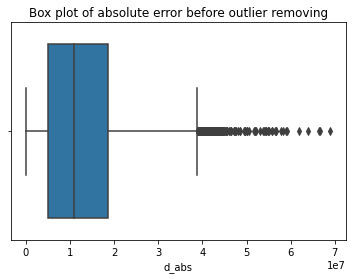

In [47]:
sns.boxplot(dftest['d_abs'])
plt.title('Box plot of absolute error before outlier removing')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


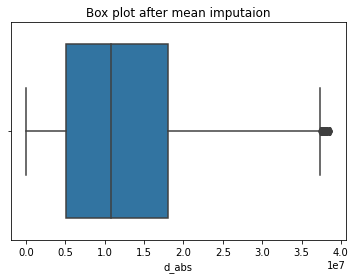

In [48]:
for i in dftest['d_abs']:
  q1= dftest['d_abs'].quantile(0.25)
  q3=dftest['d_abs'].quantile(0.75)
  iqr=q3-q1
  lower_tail=q1-1.5*iqr
  upper_tail=q3+1.5*iqr
  if i> upper_tail or i<lower_tail:
    dftest['d_abs']=dftest['d_abs'].replace(i,np.mean(dftest['d_abs']))
sns.boxplot(dftest.d_abs)
plt.title('Box plot after mean imputaion')
plt.show()

In [49]:
outliers=[]
def detect_outliers(data):
  threshold=3
  mean= np.mean(data)
  std= np.std(data)

  for i in data:
    z_score=(i-mean)/std
    if np.abs(z_score)> threshold:
      outliers.append(i)
  return outliers
outlier_pt=detect_outliers(dftest.d_abs)
outlier_pt

[38655239.683698334]

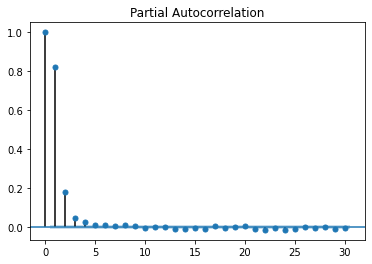

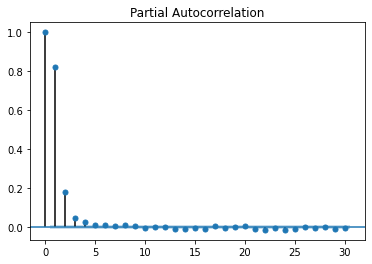

In [5]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# PACF
pacf_values = (dftest['d_abs'])
 
# plot pacf
plot_pacf(dftest['d_abs'], lags=30)

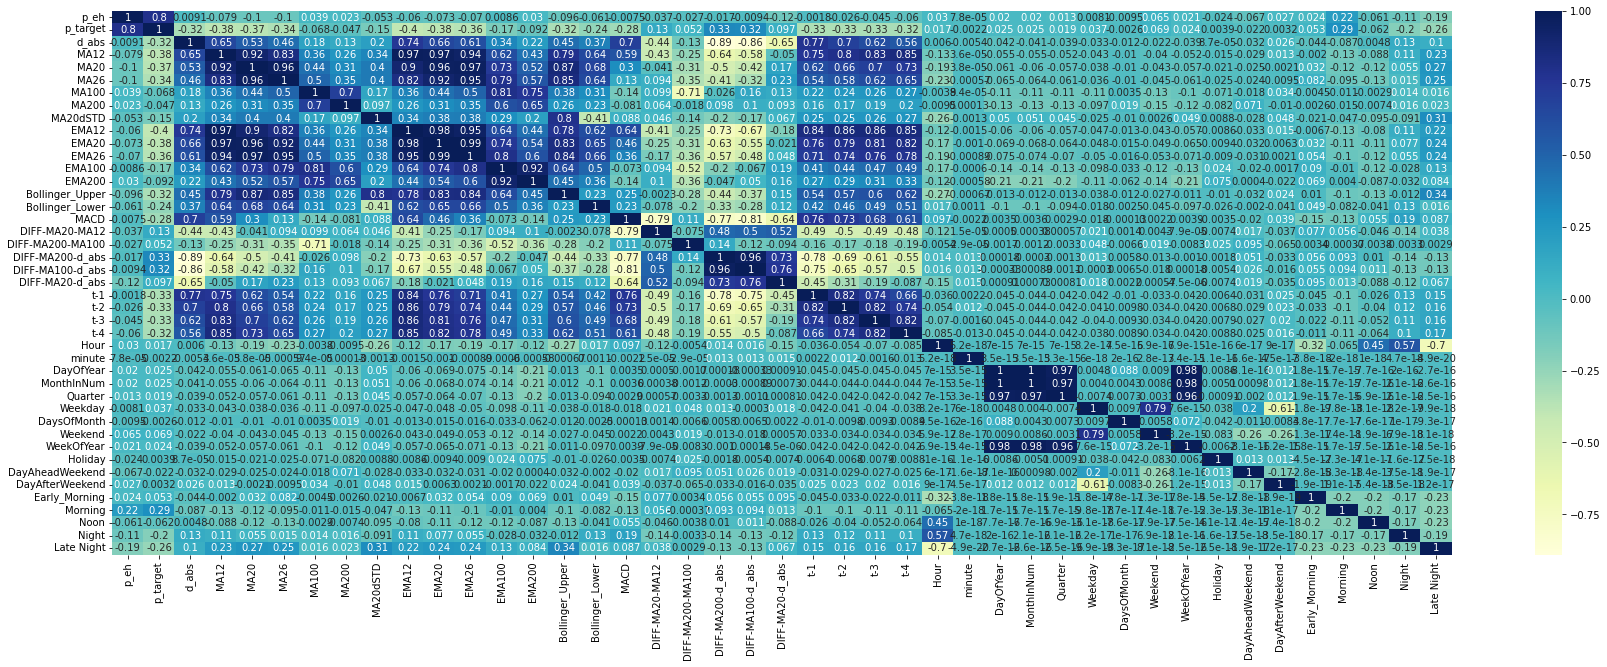

In [50]:
fig, ax = plt.subplots(1,1,figsize=(30,10))
correlation = dftest.corr() #corr() method of pandas library calculates correlation between columns of dataframe
sns.heatmap(correlation,cmap="YlGnBu",annot=True)
#plt.figsize=(16,7)
plt.show()

In [66]:
# calculate weekofmonth
from datetime import datetime as dt
from math import ceil
calendar.setfirstweekday(0)

def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """

    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))
dftest['WeekOfMonth'] = dftest['time'].apply(week_of_month)
#encoding Seasons
from sklearn.preprocessing import LabelEncoder
categorical_features = [ 'Seasons']
le = LabelEncoder()
for i in range(1):
    new = le.fit_transform(dftest[categorical_features[i]])
    dftest[categorical_features[i]] = new
df_train=dftest

Array_for_Seasons=df_train.Seasons.unique()



In [67]:
'''
#normalize features

def normalize(df):
    result = df.copy()
    for feature_name in df[['Hour','Weekday','Weekend','minute','DayAheadWeekend','Seasons','DayAfterWeekend','Holiday','Early_Morning','Morning','Noon','Night','Late Night','DaysOfMonth','DayOfYear','Quarter','MonthInNum','d_abs']]:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

en=normalize(df_train)
df_train=en
'''

#sort by Seasons
Seasons_W  = df_train.query(' Seasons==Seasons.unique()[0]')
Seasons_F  = df_train.query(' Seasons==Seasons.unique()[1]')
Seasons_S = df_train.query(' Seasons==Seasons.unique()[2]')
Seasons_H = df_train.query(' Seasons==Seasons.unique()[3]')

In [68]:
#Apply splitting( training and testing split)
import random
list_of_datasets = [Seasons_W, Seasons_S, Seasons_F,Seasons_H]
df_for_testing = pd.DataFrame(columns=df_train.columns) 
df_for_training = pd.DataFrame(columns=df_train.columns) 
for i in list_of_datasets:
  test_list=(i.DayOfYear)
  test_list_rand=random.sample(list(test_list),18)# 18 is 20 procent of the three months
  df_for_test_check=i[i.DayOfYear.isin(test_list_rand)]
  df_for_train_check=i[~(i.DayOfYear.isin(test_list_rand))]
  df_for_testing = df_for_testing.append(df_for_test_check).sort_values('time')
  df_for_training = df_for_training.append(df_for_train_check).sort_values('time')
  proportion_test =round(((df_for_testing.groupby('Weekend').size()/df_for_testing['Weekend'].count())*100).iloc[1])


In [55]:
#normalize features
'''
def normalize(df):
    result = df.copy()
    for feature_name in df[['Hour','Weekday','Weekend','minute','DayAheadWeekend','Seasons','DayAfterWeekend','Holiday','Early_Morning','Morning','Noon','Night','Late Night','DaysOfMonth','DayOfYear','Quarter','MonthInNum']]:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

en=normalize(df_for_training)
df_for_training=en
'''


In [69]:
proportion_test

28

# Neueal Network

In [71]:
#Neural Network
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

df_for_training_apart = df_for_training
X_train= df_for_training_apart[['Hour','minute','DayAfterWeekend','DayAheadWeekend','Seasons','DaysOfMonth','MonthInNum','DayOfYear','WeekOfYear','t-1','t-2','t-3','t-4','MA26','MA100','MA200','MA12','EMA12','EMA20','EMA26','EMA100','EMA200','Bollinger_Lower','Noon','Night']]
y_train = df_for_training_apart['d_abs']

X_test= df_for_testing[['Hour','minute','DayAfterWeekend','DayAheadWeekend','Seasons','DaysOfMonth','MonthInNum','DayOfYear','WeekOfYear','t-1','t-2','t-3','t-4','MA26','MA100','MA200','MA12','EMA12','EMA20','EMA26','EMA100','EMA200','Bollinger_Lower','Noon','Night']]
y_test = df_for_testing['d_abs']

model = MLPRegressor(activation='relu',alpha= 0.05,hidden_layer_sizes= (50, 50, 50),learning_rate= 'constant',solver= 'adam')
model.fit(X_train,y_train)

y_preds=model.predict(X_test)
#Evaluation metrics(not usful)
from sklearn import metrics
#print('Mean absolute percentage error:', mean_absolute_percentage_error(y_test,y_preds))
#print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_preds))
#print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_preds))
#score=np.sqrt(metrics.mean_squared_error(y_test, y_preds))
#print(f'Root Mean Squared Error:{score:0.2f}')

##Evaluation metric (MER), and the distribution of error realtively to data points per day
result = pd.DataFrame()
result['y_test'] = y_test
result['y_preds'] = y_preds
result['diff'] = abs(y_test-y_preds)
result['relative_error'] = (result['diff']*100)/result['y_test']
merged=df_for_testing
merged=merged.merge(result[['relative_error','y_preds']],how='left',left_index=True,right_index=True)
result['relative_error'].describe()



count    6624.0
mean       69.7
std      1072.0
min         0.0
25%         5.5
50%        13.3
75%        31.1
max     61921.3
Name: relative_error, dtype: float64

# Visualization of  actual/predicted  and the error 


In [ ]:
#Visualization
from enum import auto
merged=merged.set_index('time')
for date, d in merged.groupby(merged['Dates']):
  fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(16,7))
  ax1 = d['d_abs'].plot(legend=True,linestyle = '-',label='Actual value',ax=axes[0])
  ax1 = d['y_preds'].plot(color='red',legend=True,style='-',label='Predicted value',ax=axes[0])
  ax1.legend(loc='upper right')
  ax1.set_title('Actual and predicted absolute error',  fontsize=20)
  ax1.grid(b=True, which='major', color='#666666', linestyle='-') 
  ax1.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)
  ax2=sns.scatterplot(data=d,x = d.index,y=d['relative_error'],ax=axes[1], color='red')
  ax2.set_ylabel('Relative error')
  ax2.set_title('Relative error for each datapoint in a day ',  fontsize=20)
  ax2.set_xlabel(f",{d['Day'].values[0]}".replace(',', ' '),fontsize=15)
  ax2.set_xlabel(f",{d['Day'].values[0]}".replace(',', ' '),fontsize=15)
  ax1.legend(loc='upper right')
  ax2.grid(b=True, which='major', color='#666666', linestyle='-') 
  ax2.grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)
  plt.tight_layout()
  plt.xlim=auto
  plt.ylim=auto
  ax1.xlim=auto
  ax2.ylim=auto


In [ ]:
merged.relative_error.nlargest(50)

17826   998291.8
6639    203135.6
33549    14697.8
12167    13021.8
19802    12030.9
8203     11682.9
8594     10808.3
2625      9690.7
76        8472.1
15533     7599.7
17242     7333.3
15188     7240.5
16261     7204.1
12104     7090.1
4         6949.8
8176      6717.3
16229     6119.9
27287     6035.4
9519      5971.0
5346      5511.5
17899     5480.6
11196     5370.4
32595     5109.8
32711     5100.4
18787     4716.5
12133     4690.6
11624     4649.5
14210     4400.1
6490      3922.0
32477     3888.1
26246     3636.5
9520      3562.9
5         3453.9
15190     3414.2
31204     3304.8
75        3186.9
4257      3158.1
18765     3150.6
23503     3132.4
6         3131.4
57        3062.2
6638      2992.8
28649     2922.2
12105     2858.7
12237     2840.2
19807     2807.0
12        2801.8
26550     2694.9
31271     2678.4
26491     2583.8
Name: relative_error, dtype: float64